In [2]:
import sqlite3
import pandas as pd

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
def get_df(query):
    conn = sqlite3.connect('database.db')
    df = pd.read_sql_query(query, conn)
    df.reset_index(drop=True, inplace=True)
    conn.close()
    return df

df = get_df(query = '''
    SELECT cl.keywords AS "Категория отзывов",
           COUNT(com.id) AS "Количество", sentiment
    FROM comments com
    JOIN clusters cl ON cl.cluster_id = com.cluster_id
    GROUP BY cl.keywords
    ORDER BY "Количество" desc
''')

/tmp/ipykernel_5560/1856374762.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_top[col_quantity], fontsize=numbers_font_size)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

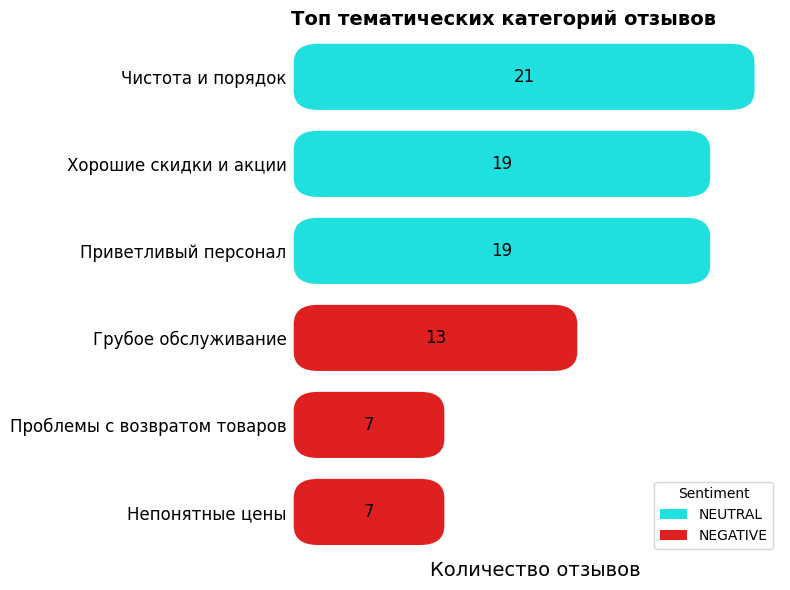

In [93]:
from matplotlib.font_manager import FontProperties
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_categories(df, col_quantity, col_category, title, title_x_axis, title_y_axis, top_n, title_font_size=12, categories_font_size=9, numbers_font_size=11):
    # Получаем топ-N записей
    df_top = df.sort_values(by=col_quantity, ascending=False).head(top_n)

    # Создаем график
    f, ax = plt.subplots(figsize=(8, 6), facecolor='none')  # Изменяем размер фигуры
    ax.patch.set_facecolor('none')
    sns.set_color_codes("colorblind")

    # Цвета для каждого типа sentiment
    colors = {'POSITIVE': 'green', 'NEUTRAL': 'cyan', 'NEGATIVE': 'red'}

    # Создаем график с использованием seaborn
    barplot = sns.barplot(x=col_quantity, y=col_category, data=df_top, hue="sentiment", palette=colors, dodge=False, ax=ax)

    # Перемещаем подписи для каждого набора столбцов в середину столбца
    for p in ax.patches:
        ax.text(p.get_width() / 2, p.get_y() + p.get_height() / 2, "%.0f" % p.get_width(), fontsize=numbers_font_size, ha='center', va='center')

    sns.despine(left=True, bottom=True)

    # Добавляем легенду с подписями и заголовком
    ax.legend(title='Sentiment', loc="lower right")

    # Добавляем заголовок
    ax.set_title(title, fontweight='bold', loc='left', fontsize=title_font_size)

    # Добавляем скругленные углы к столбцам
    new_patches = []
    for patch in reversed(ax.patches):
        bb = patch.get_bbox()
        color = patch.get_facecolor()
        p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                                abs(bb.width), abs(bb.height),
                                boxstyle="round,pad=-0.1,rounding_size=1.1",
                                ec="none", fc=color,
                                mutation_aspect=0.2
                                )
        patch.remove()
        new_patches.append(p_bbox)

    for patch in new_patches:
        ax.add_patch(patch)

    # Устанавливаем подписи для осей
    ax.set_ylabel(title_y_axis, fontsize=title_font_size)
    ax.set_xlabel(title_x_axis, fontsize=title_font_size)
    
    # Устанавливаем метки для оси X
    ax.set_xticklabels(df_top[col_quantity], fontsize=numbers_font_size)
    
    # Убираем деления на оси X
    ax.xaxis.set_ticks_position('none')
    
    # Убираем подписи для осей и делаем макет компактным
    ax.set_xticks([])
    ax.tick_params(axis='y', length=0, labelsize=categories_font_size)
    plt.tight_layout()

    # Показываем график
    plt.savefig('top_categories_plot.png', dpi=300, facecolor='w', edgecolor='w')

# Пример использования функции с новыми параметрами
plot_top_categories(df, "Количество", "Категория отзывов", "Топ тематических категорий отзывов", "Количество отзывов", "", 6, title_font_size=14, categories_font_size=12, numbers_font_size=12)




In [167]:
import sqlite3
import pandas as pd
import plotly.express as px
import requests
import plotly.io as pio

def get_coordinates_nominatim(address):
    base_url = 'https://nominatim.openstreetmap.org/search'
    params = {
        'q': address,
        'format': 'json',
        'limit': 1
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if len(data) == 0:
        return None, None

    latitude = float(data[0]['lat'])
    longitude = float(data[0]['lon'])

    return latitude, longitude

def plot_map_from_database(database_path, city_name):
    # Получаем координаты города по его названию
    city_coordinates = get_coordinates_nominatim(city_name)
    if city_coordinates is None:
        print(f"Ошибка: Невозможно определить координаты города {city_name}")
        return

    # Подключаемся к базе данных SQLite
    conn = sqlite3.connect(database_path)

    # Извлекаем данные из таблицы comments
    comments_df = pd.read_sql_query("SELECT address, COUNT(*) as count, avg(CASE WHEN sentiment = 'NEGATIVE' THEN -1 WHEN sentiment = 'NEUTRAL' THEN 0 WHEN sentiment = 'POSITIVE' THEN 1 END) AS sentiment_numeric FROM comments GROUP BY address", conn)

    # Получаем координаты для каждого адреса
    comments_df['latitude'] = None
    comments_df['longitude'] = None
    for index, row in comments_df.iterrows():
        latitude, longitude = get_coordinates_nominatim(row['address'])
        comments_df.at[index, 'latitude'] = latitude
        comments_df.at[index, 'longitude'] = longitude

    # Удаляем строки с нулевыми координатами
    comments_df = comments_df.dropna(subset=['latitude', 'longitude'])

    # Закрываем соединение с базой данных
    conn.close()

    # Создаем интерактивную карту с помощью Plotly
    fig = px.scatter_mapbox(comments_df, lat="latitude", lon="longitude", size="count", zoom=10,
                            center=dict(lat=city_coordinates[0], lon=city_coordinates[1]),
                            color="sentiment_numeric", color_continuous_scale=px.colors.diverging.RdYlGn,
                            color_continuous_midpoint=0)
    fig.update_layout(mapbox_style="carto-positron")  # Черно-белая карта
    fig.show()

# Пример использования функции
city_name = "Санкт-Петербург"
plot_map_from_database('database.db', city_name)

